In [16]:
import os
import csv
from PIL import Image
import numpy as np
import numpy.linalg as la
from scipy import linalg
from scipy import spatial
from scipy import signal
import matplotlib.pyplot as plt
from math import *
import time

%matplotlib inline

In [17]:
def gkern(kernlen, std):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

In [18]:
def Gaussian_pixels(L1,W1,L2,W2,sizeG,std,nml,tr=3,sc=1):
    x_0 = np.zeros((L1*W1,2))
    for i in range(L1*W1):
        x_0[i][0] = (i//W1)/L1
        x_0[i][1] = (i%W1)/W1

    # y_0 = x_0
    
    y_0 = np.zeros((L2*W2,2))
    for i in range(L2*W2):
        y_0[i][0] = (i//W2)/L2
        y_0[i][1] = (i%W2)/W2

    Gaussian_1 = gkern(sizeG,std)
    Gaussian_2 = gkern(sizeG,sc*std)
    
    rec_x = np.zeros((L1,W1))
    rec_y = np.zeros((L2,W2))
    rec_x[2:sizeG+2,2:sizeG+2] = Gaussian_1
    rec_y[2+tr:sizeG+2+tr,tr+2:sizeG+tr+2] = Gaussian_2

    pixels_1 = rec_x.flatten()
    n_pixels_1 = np.array([1.0/pixels_1.sum()*pixels_1])
    pixels_2 = rec_y.flatten()
    n_pixels_2 = np.array([1.0/pixels_2.sum()*pixels_2])

    x = np.concatenate(((L1/nml)*x_0,n_pixels_1.T),axis=1)
    y = np.concatenate(((L1/nml)*y_0,n_pixels_2.T),axis=1)
    
    return x,y,pixels_1,pixels_2

In [19]:
def ellipse(major,minor,std_1,std_2):
    G1 = signal.gaussian(major, std_1).reshape(major, 1)
    G2 = signal.gaussian(minor, std_2).reshape(minor, 1)
    E = np.outer(G1,G2)
    return E

def ellipse_pixels(L1,W1,L2,W2,major,minor,std_1,std_2,nml,tr=0,sc=1):
    x_0 = np.zeros((L1*W1,2))
    for i in range(L1*W1):
        x_0[i][0] = (i//W1)/L1
        x_0[i][1] = (i%W1)/W1

    # y_0 = x_0
    
    y_0 = np.zeros((L2*W2,2))
    for i in range(L2*W2):
        y_0[i][0] = (i//W2)/L2
        y_0[i][1] = (i%W2)/W2

    E_1 = ellipse(major,minor,std_1,std_2)
    E_2 = ellipse(minor,major,std_2,std_1)
    
    rec_x = np.zeros((L1,W1))+1e-10
    rec_y = np.zeros((L2,W2))+1e-10
    rec_x[2:major+2,2:minor+2] = E_1
    rec_y[2+tr:minor+2+tr,tr+2:major+tr+2] = E_2

    pixels_1 = rec_x.flatten()
    n_pixels_1 = np.array([1.0/pixels_1.sum()*pixels_1])
    pixels_2 = rec_y.flatten()
    n_pixels_2 = np.array([1.0/pixels_2.sum()*pixels_2])

    x = np.concatenate(((L1/nml)*x_0,n_pixels_1.T),axis=1)
    y = np.concatenate(((L1/nml)*y_0,n_pixels_2.T),axis=1)
    
    return x,y,pixels_1,pixels_2

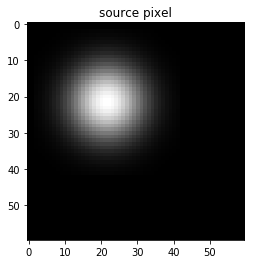

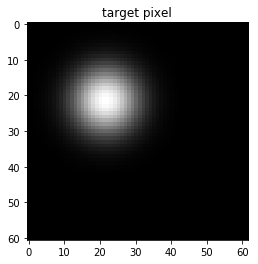

In [20]:
###x: Generate an image of 2D Gaussian kernel, with image size of 60x60 pixels###
###y: Generate an image of 2D Gaussian kernel, with image size of 61x62 pixels###
x,y,pixels_1,pixels_2 = Gaussian_pixels(60,60,61,62,40,7,100,tr=0,sc=0.9)
image_count = 0
faceX = np.reshape(pixels_1,(60,60))
image_count+=1
plt.figure(image_count)
plt.title('source pixel')
plt.imshow(faceX,cmap=plt.cm.gray)
# plt.show('hold')

faceX = np.reshape(pixels_2,(61,62))
image_count+=1
plt.figure(image_count)
plt.title('target pixel')
plt.imshow(faceX,cmap=plt.cm.gray)
# plt.show('hold')

In [21]:
def cutoff(x):
    ###drop pixels with intensity below a certain level; this case we drop pixels with intensity value 0
    nx = []
    for i in range(len(x)):
        if x[i][2] != 0:
            nx.append(x[i])
    return np.array(nx)

In [22]:
def Tx(x,y):
    ###Explicit optimal transport map from a Gaussian distribution (mx,vx) to another Gaussian distribution (my,vy)
    x_0 = x[:,:2]
    y_0 = y[:,:2]
    mx = np.average(x_0,axis=0,weights = x[:,2])
    my = np.average(y_0,axis=0,weights = y[:,2])
    vx = np.cov(x_0.T,aweights = x[:,2])
    vy = np.cov(y_0.T,aweights = y[:,2])
    
    
    sqrt = linalg.sqrtm(vx)
    ml = np.matmul(sqrt,vy)
    m = np.matmul(ml,sqrt)
    sqrt_inv = la.inv(sqrt)
    l = np.matmul(sqrt_inv,linalg.sqrtm(m))
    A = np.matmul(l,sqrt_inv)
    
    x_T = np.zeros((len(x),2))
    x_T = my+np.einsum('ij,jk->ik',A,(x_0-mx).T).T
    
    return x_T
    
def Ty(y,x):
    ###Explicit optimal transport map from a Gaussian distribution (my,vy) to another Gaussian distribution (mx,vx)
    x_0 = x[:,:2]
    y_0 = y[:,:2]
    mx = np.average(x_0,axis=0,weights = x[:,2])
    my = np.average(y_0,axis=0,weights = y[:,2])
    vx = np.cov(x_0.T,aweights = x[:,2])
    vy = np.cov(y_0.T,aweights = y[:,2])
    
    sqrt = linalg.sqrtm(vy)
    ml = np.matmul(sqrt,vx)
    m = np.matmul(ml,sqrt)
    sqrt_inv = la.inv(sqrt)
    l = np.matmul(sqrt_inv,linalg.sqrtm(m))
    A = np.matmul(l,sqrt_inv)
    
    y_T = np.zeros((len(y),2))
    y_T = mx+np.einsum('ij,jk->ik',A,(y_0-my).T).T
    
    return y_T

def compose(x,y,p):
    twx = x.sum(axis=0)[2]
    twy = y.sum(axis=0)[2]
    
    x[:,2] = p/twx*x[:,2]
    y[:,2] = (1-p)/twy*y[:,2]
    
    return np.concatenate([x,y])

####two ways to initialize intermediate sets of points, interpolate_1 picks points using weights of each points
####interpolate_2 picks points with uniform probability
####interpolate_2 works better in practice
def interpolate_1(x,y,K):
    Nx = len(x)
    Ny = len(y)
    d1 = np.arange(Nx)
    d2 = np.arange(Ny)
    wx = x[:,2]
    wy = y[:,2]
    
    x_T = Tx(x,y)
    x_K = x_T
    y_T = Ty(y,x)
    mu = []
    mu.append(x)
    
    z0k = np.zeros((Nx,3))
    zKk = np.zeros((Ny,3))
    z0k[:,2] = x[:,2]
    zKk[:,2] = y[:,2]
    rx = np.random.choice(d1, Nx,replace=False, p=wx)
    ry = np.random.choice(d2, Ny,replace=False, p=wy)
    for k in range(1,K):
        z0k[:,:2] = (1-k/K)*x[:,:2]+(k/K)*x_T[:,:2]
        zx = z0k[rx]
        rx_sum=0
        for i in range(Nx):
            if rx_sum >= 1-k/K:
                break
            rx_sum += zx[i][2]
        

        zKk[:,:2] = (1-k/K)*y_T[:,:2]+(k/K)*y[:,:2]
        zy = zKk[ry]
        ry_sum=0
        for j in range(Ny):
            if ry_sum >= k/K:
                break
            ry_sum += zy[j,2]
        z = compose(zx[:i],zy[:j],1-k/K)
        mu.append(z)
    mu.append(y)
    
    return mu,x_K,y_T 

def interpolate_2(x,y,K):
    Nx = len(x)
    Ny = len(y)
    wx = x[:,2]
    wy = y[:,2]
    
    x_T = Tx(x,y)
    x_K = x_T
    y_T = Ty(y,x)
    mu = []
    mu.append(x)
    
    z0k = np.zeros((Nx,3))
    zKk = np.zeros((Ny,3))
    z0k[:,2] = x[:,2]
    zKk[:,2] = y[:,2]
    
    rx = np.random.choice(np.arange(Nx),Nx,replace=False)
    ry = np.random.choice(np.arange(Ny),Ny,replace=False)
    
    for k in range(1,K):
        z0k[:,:2] = (1-k/K)*x[:,:2]+(k/K)*x_T[:,:2]
        zx = z0k[rx]
        
        

        zKk[:,:2] = (1-k/K)*y_T[:,:2]+(k/K)*y[:,:2]
        zy = zKk[ry]
        z = compose(zx[:int(Nx*(1-k/K))],zy[:int(Ny*k/K)],1-k/K)
        mu.append(z)
    mu.append(y)
    
    return mu, x_K,y_T

def interpolate_linear(x,y,K):
    Nx = len(x)
    Ny = len(y)
    x_T = Tx(x,y)
    x_K = x_T
    y_T = Ty(y,x)
    mu = []
    mu.append(x)
    for k in range(1,K):
        l = np.zeros((Nx,3))
        l[:,:2] = (1-k/K)*x[:,:2]+(k/K)*x_T[:,:2]
        l[:,2] = x[:,2]
        
        mu.append(l)
    mu.append(y)
    
    return mu,x_K,y_T

In [34]:
def rho_T(x,T,rho_x,delta = 5e3):
    T0 = T[:,0]
    T1 = T[:,1]
    x0T0 = x[0]-T[:,0]
    x1T1 = x[1]-T[:,1]
    argexp = -delta*(x0T0**2+x1T1**2)
    exp_v = np.exp(argexp)
    return exp_v.dot(rho_x)

In [25]:
# ###test interpolate_1
# x_c = cutoff(x)
# y_c = cutoff(y)
# mu_n, x_K, y_0 = interpolate_1(x_c,y_c,80)

# for k in range(len(mu_n)):
#     if k%5 == 0:
#         pixels_mu = np.array([rho_T(x[i,:2],mu_n[k][:,:2],mu_n[k][:,2]) for i in range(100**2)])
#         imgT = np.reshape(pixels_mu,(100,100))
#         plt.figure(k)
#         plt.title('pic')
#         plt.imshow(imgT,cmap=plt.cm.gray)
#         plt.show('hold')
# #         plt.scatter(mu_n[k][:,0],mu_n[k][:,1], color='red',marker = 'x');
# #         plt.show('hold')

In [26]:
###test interpolate_2
# x_c = cutoff(x)
# y_c = cutoff(y)
# mu_n, x_K, y_0 = interpolate_2(x_c,y_c,80)

# for k in range(len(mu_n)):
#     if k%5 == 0:
#         pixels_mu = np.array([rho_T(x[i,:2],mu_n[k][:,:2],mu_n[k][:,2]) for i in range(100**2)])
#         imgT = np.reshape(pixels_mu,(100,100))
#         plt.figure(k)
#         plt.title('pic')
#         plt.imshow(imgT,cmap=plt.cm.gray)
#         plt.show('hold')
# #         plt.scatter(mu_n[k][:,0],mu_n[k][:,1], color='red',marker = 'x');
# #         plt.show('hold')

# Local algorithm

In [27]:
def Linear_LGH(x,y,a,b,returnGH=True,d=2):
    da = len(a)
    db = len(b)
    Nx = len(x)
    Ny = len(y)
    
    x0 = x[:,0]
    x1 = x[:,1]
    
    T = np.zeros((Nx,2))
    T[:,0] = a[0] + (1+a[2])*x0+a[3]*x1
    T[:,1] = a[1] + a[3]*x0+(1+a[4])*x1
    
    T0 = T[:,0]
    T1 = T[:,1]
    y0 = y[:,0]
    y1 = y[:,1]
    gy = b[0]+ b[1]*y0+b[2]*y1+0.5*b[3]*y0**2+b[4]*y0*y1+0.5*b[5]*y1**2
    gT =b[0]+ b[1]*T0+b[2]*T1+0.5*b[3]*T0**2+b[4]*T0*T1+0.5*b[5]*T1**2
    
    L = np.average(gT,weights=x[:,2]) - np.average(np.exp(gy),weights=y[:,2])
    
    if not returnGH:
        return(L)
    
    else:
        #first derivatives
        gzT = np.zeros((Nx,2))
        gzT[:,0] = b[1]+b[3]*T0+b[4]*T1
        gzT[:,1] = b[2]+b[4]*T0+b[5]*T1
        
        daT = np.zeros((Nx,da,d))
        daT[:,0,:] = np.array([1,0])
        daT[:,1,:] = np.array([0,1])
        daT[:,2,0] = x0
        daT[:,3,0] = x1
        daT[:,3,1] = x0
        daT[:,4,1] = x1
        
        #gradient w.r.t. a
        ngzT = np.einsum('i,ij->ij',x[:,2],gzT)
        daL = np.einsum('ijk,ik->j',daT,ngzT)
        
        expgy = np.exp(gy)
        nexpgy = np.exp(gy)*y[:,2]
        dbgy = np.zeros((Ny,db))
        dbgT = np.zeros((Nx,db))
        dbgy[:,0] = np.ones(Ny)
        dbgT[:,0] = np.ones(Nx)
        dbgy[:,1] = y0
        dbgT[:,1] = T0
        dbgy[:,2] = y1
        dbgT[:,2] = T1
        dbgy[:,3] = 0.5*y0**2
        dbgT[:,3] = 0.5*T0**2
        dbgy[:,4] = y0*y1
        dbgT[:,4] = T0*T1
        dbgy[:,5] = 0.5*y1**2
        dbgT[:,5] = 0.5*T1**2
        
        #gradient w.r.t. b
        ndbgT = np.einsum('i,ij->ij',x[:,2],dbgT)
        dbL = np.sum(ndbgT,axis=0) - np.einsum('ik,i->k',dbgy,nexpgy)
        
        #gradient
        G = np.concatenate([daL,dbL],axis=0)
        
        #second derivatives
        gzzT = np.zeros((Nx,d,d))
        gzzT[:,0,0] = b[3]
        gzzT[:,1,0] = b[4]
        gzzT[:,0,1] = gzzT[:,1,0]
        gzzT[:,1,1] = b[5]
        
        daaT = np.zeros((Nx,da,da,d))
        
        ngzzT = np.einsum('i,ijk->ijk',x[:,2],gzzT)
        daaL = np.einsum('ijkl,il->jk',daaT,ngzT) + np.einsum('ijl,ilm,ikm->jk',daT,ngzzT,daT)
        
        dbzgT = np.zeros((Nx,db,d))
        dbzgT[:,1,0]=np.ones(Nx)
        dbzgT[:,2,1]=np.ones(Nx)
        dbzgT[:,3,0]=T0
        dbzgT[:,4,0]=T1
        dbzgT[:,4,1]=T0
        dbzgT[:,5,1]=T1
        ndbzgT = np.einsum('i,ijk->ijk',x[:,2],dbzgT)
        
        # #Hessian w.r.t. ab
        dabL = np.einsum('ikl,ijl->jk',ndbzgT,daT)
        
        dbbgy = np.zeros((Ny,db,db))
        dbbgT = np.zeros((Nx,db,db))
        dbgdbg = np.einsum('jn,jm->jnm',dbgy,dbgy)
        ndbbgT = np.einsum('i,ijk->ijk',x[:,2],dbbgT)
        
        dbbL = np.sum(ndbbgT,axis=0) - np.einsum('jnm,j->nm',(dbbgy+dbgdbg),nexpgy)
        
        #Hessian
        H = np.zeros((da+db,da+db))
        H[:da,:da] = daaL
        H[:da,da:] = dabL
        H[da:,:da] = dabL.T
        H[da:,da:] = dbbL
        return(L,G,H)

In [28]:
def linear_local_ot_debug(x, y, Niter=200, eps=1e-5, eta0=0.05, da=5, db=6, eta_min = 1e-4, eta_max=1e6, gamma = 5.2):
    x_c = cutoff(x)
    y_c = cutoff(y)
    Nx = len(x)
    Ny = len(y)

    eta = eta0
    etaC = 2.0

    #setting up initial b, and minvar,D
#     vx = np.cov(x[:,:2].T,aweights=x[:,2])
#     vy = np.cov(y[:,:2].T,aweights=y[:,2])
    vx = np.cov(x_c[:,:2].T)
    vy = np.cov(y_c[:,:2].T)
    mx = np.average(x[:,:2],axis=0,weights=x[:,2])
    my = np.average(y[:,:2],axis=0,weights=y[:,2])

    a0 = np.zeros(da)
    #initial b
    b0 = np.zeros(db)
    B0 = 0.5*(la.inv(vy)-la.inv(vx))
    b0[3] = B0[0,0]
    b0[4] = B0[0,1]+B0[1,0]
    b0[5] = B0[1,1]
    B1 = la.solve(vx,mx) - la.solve(vy,my)
    b0[1] = B1[0]
    b0[2] = B1[1]
    b0[0] = 0.5*(my.dot(la.solve(vy,my)) - mx.dot(la.solve(vx,mx))+np.log(la.det(vy)/la.det(vx)))

    z = np.concatenate([a0,b0],axis=0)
    J = np.eye(da+db)
    J[da:,da:] *= -1

    #   initialize gradients  
    a = a0
    b = b0
    Ln,Gn,Hn = Linear_LGH(x,y,a,b)

    x0 = x[:,0]
    x1 = x[:,1]

    T = np.zeros((Nx,3))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1
    T[:,2] = x[:,2]
    
    ####debug####  
    listG = []
    listeta = []
    Lnn = []
    Lnnp1 = []
    Lnp1n = []
    #############
    
    for n in range(Niter):
        zold = z
        nz = z
        Gn_norm = la.norm(Gn,2)
        ###################
        listG.append(la.norm(Gn,2))
        listeta.append(eta)
        ###################
        
        if Gn_norm < eps:
            break
        #   delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
        validity = False
        eta = min(gamma*eta, eta_max)
        iters = 0
        while(not validity):
            iters += 1
            eta = eta/2.0
            if eta < eta_min:
                break
            dz = -la.solve((1.0/eta)*J+Hn,Gn)
            nz = zold + dz
            Ln1 = Linear_LGH(x,y,nz[:da],nz[da:],returnGH=False)
            Lan1 = Linear_LGH(x,y,nz[:da],zold[da:],returnGH=False)
            Lbn1 = Linear_LGH(x,y,zold[:da],nz[da:],returnGH=False)
            v_0 = (Ln1<=Lbn1+1e-16) and (Lan1<=Ln1+1e-16)
            validity = v_0 or (iters>=10)
        z = z + dz
        Lnn.append(Ln1)
        Lnnp1.append(Lbn1)
        Lnp1n.append(Lan1)
        Ln,Gn,Hn = Linear_LGH(x,y,z[:da],z[da:])
    a,b = z[:da],z[da:]
    T = np.zeros((Nx,3))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1
    T[:,2] = x[:,2]
    
    return T,a,b,[listG,listeta,Lnn,Lnnp1,Lnp1n]

## Test local optimal transport of two similar image with small differences

In [29]:
T, a, b, Ls= linear_local_ot_debug(x,y,Niter=400,eps=1e-6,eta0=0.05,gamma = 2.5)

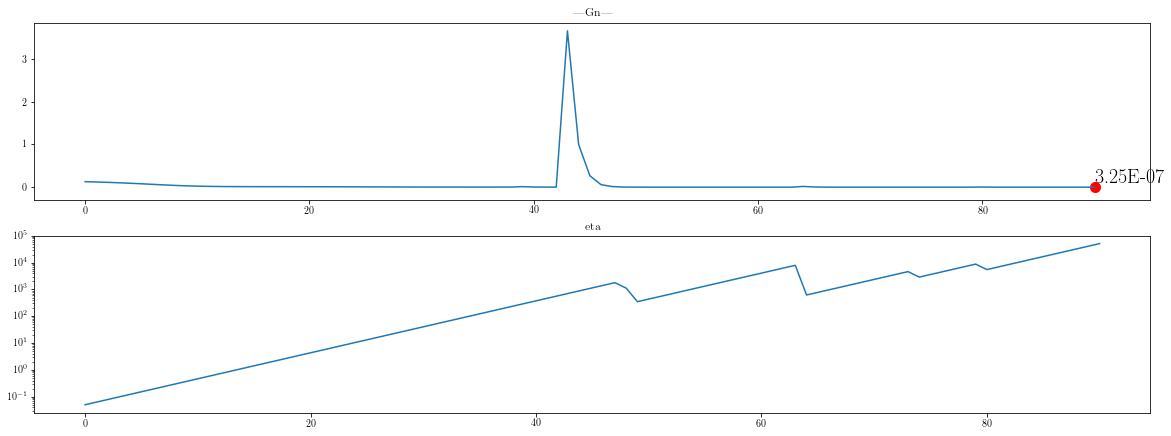

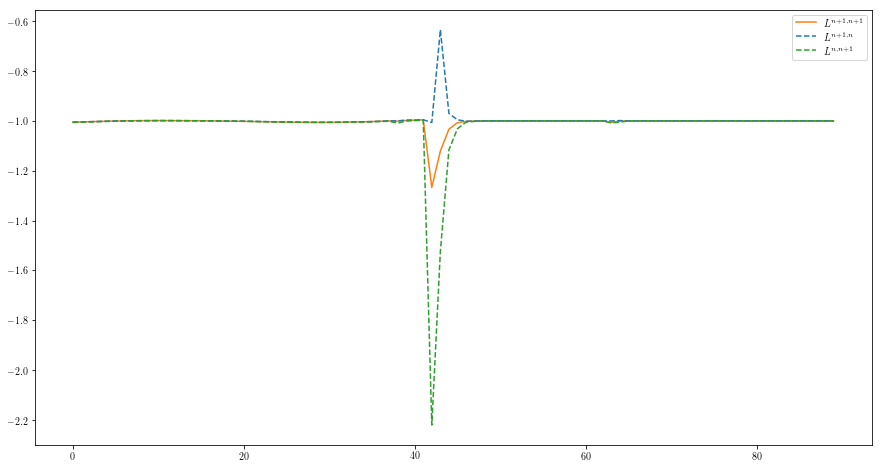

In [37]:
from decimal import Decimal
from matplotlib import rc
#####DEBUG#####
#find minimal Gn, Dn
minG = np.min(Ls[0])
iminG = np.argmin(Ls[0])

fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(Ls[0])
ax1.scatter(iminG,minG, c = 'r', s = 100)
decG = '%.2E' % Decimal(minG)
ax1.annotate(decG, (iminG,minG+0.1), fontsize=20)
ax1.set_title('|Gn|')
# ax1.axvline(iminD, c = 'black', ls = 'dotted')

ax2 = fig.add_subplot(4, 1, 2)
ax2.semilogy(Ls[1])
# ax4.axvline(iminD, c = 'black', ls = 'dotted')
ax2.set_title('eta');
###############
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
iterations = range(len(Ls[0])-1)
plt.plot(iterations,Ls[2], label=r'$L^{n+1,n+1}$', c='C1')
plt.plot(iterations,Ls[3], label=r'$L^{n+1,n}$', c='C0', linestyle='--')
plt.plot(iterations,Ls[4], label=r'$L^{n,n+1}$',c='C2', linestyle='--')
plt.legend()
# plt.ylim(ymin=-1.00001, ymax=-0.99999)

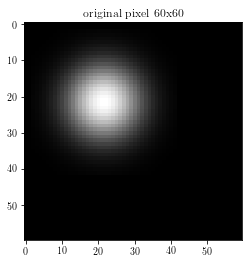

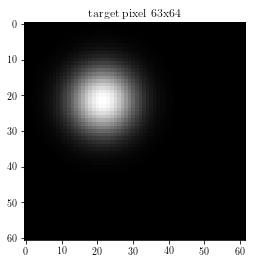

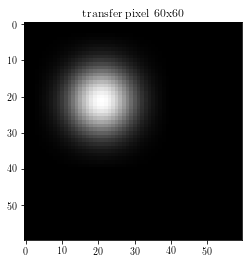

In [35]:
pixels_T = np.array([rho_T(x[i,:2],T[:,:2],T[:,2]) for i in range(len(x))])
image_count = 0
faceX = np.reshape(pixels_1,(60,60))
image_count+=1
plt.figure(image_count)
plt.title('original pixel 60x60')
plt.imshow(faceX,cmap=plt.cm.gray)
plt.show('hold')

faceY = np.reshape(pixels_2,(61,62))
image_count+=1
plt.figure(image_count)
plt.title('target pixel 63x64')
plt.imshow(faceY,cmap=plt.cm.gray)
plt.show('hold')

faceT = np.reshape(pixels_T,(60,60))
image_count+=1
plt.figure(image_count)
plt.title('transfer pixel 60x60')
plt.imshow(faceT,cmap=plt.cm.gray)
plt.show('hold')

# Global algorithm

In [22]:
def linear_local_ot(x, y, Niter=200, eps=1e-5, eta0=0.05, da=5, db=6, eta_min = 1e-4, eta_max=1e6, gamma = 5.2):
    x_c = cutoff(x)
    y_c = cutoff(y)
    Nx = len(x)
    Ny = len(y)

    eta = eta0
    etaC = 2.0

    #setting up initial b, and minvar,D
#     vx = np.cov(x[:,:2].T,aweights=x[:,2])
#     vy = np.cov(y[:,:2].T,aweights=y[:,2])
    vx = np.cov(x_c[:,:2].T)
    vy = np.cov(y_c[:,:2].T)
    mx = np.average(x[:,:2],axis=0,weights=x[:,2])
    my = np.average(y[:,:2],axis=0,weights=y[:,2])

    a0 = np.zeros(da)
    #initial b
    b0 = np.zeros(db)
    B0 = 0.5*(la.inv(vy)-la.inv(vx))
    b0[3] = B0[0,0]
    b0[4] = B0[0,1]+B0[1,0]
    b0[5] = B0[1,1]
    B1 = la.solve(vx,mx) - la.solve(vy,my)
    b0[1] = B1[0]
    b0[2] = B1[1]
    b0[0] = 0.5*(my.dot(la.solve(vy,my)) - mx.dot(la.solve(vx,mx))+np.log(la.det(vy)/la.det(vx)))

    z = np.concatenate([a0,b0],axis=0)
    J = np.eye(da+db)
    J[da:,da:] *= -1

    #   initialize gradients  
    a = a0
    b = b0
    Ln,Gn,Hn = Linear_LGH(x,y,a,b)

    x0 = x[:,0]
    x1 = x[:,1]

    T = np.zeros((Nx,3))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1
    T[:,2] = x[:,2]
    
#     ####debug####  
#     listG = []
#     listeta = []
#     Lnn = []
#     Lnnp1 = []
#     Lnp1n = []
#     #############
    
    for n in range(Niter):
        zold = z
        nz = z
        Gn_norm = la.norm(Gn,2)
#         ###################
#         listG.append(la.norm(Gn,2))
#         listeta.append(eta)
#         ###################
        
        if Gn_norm < eps:
            break
        #   delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
        validity = False
        eta = min(gamma*eta, eta_max)
        iters = 0
        while(not validity):
            iters += 1
            eta = eta/2.0
            if eta < eta_min:
                break
            dz = -la.solve((1.0/eta)*J+Hn,Gn)
            nz = zold + dz
            Ln1 = Linear_LGH(x,y,nz[:da],nz[da:],returnGH=False)
            Lan1 = Linear_LGH(x,y,nz[:da],zold[da:],returnGH=False)
            Lbn1 = Linear_LGH(x,y,zold[:da],nz[da:],returnGH=False)
            v_0 = (Ln1<=Lbn1+1e-16) and (Lan1<=Ln1+1e-16)
            validity = v_0 or (iters>=10)
        z = z + dz
#         Lnn.append(Ln1)
#         Lnnp1.append(Lbn1)
#         Lnp1n.append(Lan1)
        Ln,Gn,Hn = Linear_LGH(x,y,z[:da],z[da:])
    a,b = z[:da],z[da:]
    T = np.zeros((Nx,3))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1
    T[:,2] = x[:,2]
    
    return T,a,b

In [70]:
def global_ot(x,y,K=40,Maxiter=100,tol=1e-2):
    x_c = cutoff(x)
    y_c = cutoff(y)
    Nx = len(x)
    Ny = len(y) 
    a_maps = K*[0]
    b_maps = K*[0]
    
    mu, x_K, y_0 = interpolate_2(x_c,y_c,K)
    for niter in range(Maxiter):
        print(niter/Maxiter * 100)#debug
        x_Kold=x_K
        #solve local OT's
        z = x_c
        for k in range(1,K+1):


            print('Step k = '+str(k))
            pixels_z = np.array([rho_T(x[i,:2],z[:,:2],z[:,2]) for i in range(100**2)])
            imgz = np.reshape(pixels_z,(100,100))
            plt.figure(3*(k-1))
            plt.title('Before local OT z')
            plt.imshow(imgz,cmap=plt.cm.gray)
            plt.show('hold')

            pixels_mu = np.array([rho_T(x[i,:2],mu[k][:,:2],mu[k][:,2]) for i in range(100**2)])
            imgmu = np.reshape(pixels_mu,(100,100))
            plt.figure(3*(k-1)+1)
            plt.title('Before local OT mu')
            plt.imshow(imgmu,cmap=plt.cm.gray)
            plt.show('hold')


            #solve local transport problem
            Tloc,a,b = linear_local_ot(z,mu[k],Niter=200,gamma=2.5)


            pixels_T = np.array([rho_T(x[i,:2],Tloc[:,:2],Tloc[:,2]) for i in range(100**2)])
            imgT = np.reshape(pixels_T,(100,100))
            plt.figure(3*(k-1)+2)
            plt.title('After local OT z')
            plt.imshow(imgT,cmap=plt.cm.gray)
            plt.show('hold')

            a_maps[k-1] = a
            b_maps[k-1] = b
            z = Tloc
        x_K = z
    
        if (1/Nx)*la.norm(x_K[:,:2]-x_Kold[:,:2],2)<tol:
            break
        #update intermediate distributions
        for k in range(1,K):
            mu[k] = np.zeros((len(x_c),3))
            mu[k][:,:2] = (1-k/K)*x_c[:,:2]+(k/K)*x_K[:,:2]
            mu[k][:,2] = x_c[:,2]

    print('done')
    return x_K,a_maps,b_maps

In [6]:
x_K,a_maps,b_maps = global_ot(x,y,K=80)